In [1]:
import re
import numpy as np
import pandas as pd
import collections
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.model_selection import train_test_split
from unidecode import unidecode
from nltk.util import ngrams
from tqdm import tqdm
import time

In [2]:
permulaan = [
    'bel',
    'se',
    'ter',
    'men',
    'meng',
    'mem',
    'memper',
    'di',
    'pe',
    'me',
    'ke',
    'ber',
    'pen',
    'per',
]

hujung = ['kan', 'kah', 'lah', 'tah', 'nya', 'an', 'wan', 'wati', 'ita']

def naive_stemmer(word):
    assert isinstance(word, str), 'input must be a string'
    hujung_result = re.findall(r'^(.*?)(%s)$' % ('|'.join(hujung)), word)
    word = hujung_result[0][0] if len(hujung_result) else word
    permulaan_result = re.findall(r'^(.*?)(%s)' % ('|'.join(permulaan[::-1])), word)
    permulaan_result.extend(re.findall(r'^(.*?)(%s)' % ('|'.join(permulaan)), word))
    mula = permulaan_result if len(permulaan_result) else ''
    if len(mula):
        mula = mula[1][1] if len(mula[1][1]) > len(mula[0][1]) else mula[0][1]
    return word.replace(mula, '')

In [3]:
def build_dataset(words, n_words):
    count = [['GO', 0], ['PAD', 1], ['EOS', 2], ['UNK', 3]]
    counter = collections.Counter(words).most_common(n_words)
    count.extend(counter)
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 3)
        if index == 0:
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary


def classification_textcleaning(string):
    string = re.sub(
        'http\S+|www.\S+',
        '',
        ' '.join(
            [i for i in string.split() if i.find('#') < 0 and i.find('@') < 0]
        ),
    )
    string = unidecode(string).replace('.', ' . ').replace(',', ' , ')
    string = re.sub('[^A-Za-z ]+', ' ', string)
    string = re.sub(r'[ ]+', ' ', string).strip()
    string = ' '.join(
        [i for i in re.findall('[\\w\']+|[;:\-\(\)&.,!?"]', string) if len(i)]
    )
    string = string.lower().split()
    string = [(naive_stemmer(word), word) for word in string]
    return (
        ' '.join([word[0] for word in string if len(word[0]) > 1]),
        ' '.join([word[1] for word in string if len(word[0]) > 1]),
    )


def str_idx(corpus, dic, maxlen, UNK = 3):
    X = np.zeros((len(corpus), maxlen))
    for i in range(len(corpus)):
        for no, k in enumerate(corpus[i].split()[:maxlen][::-1]):
            X[i, -1 - no] = dic.get(k,UNK)
    return X

In [4]:
with open('subjectivity-negative-translated.txt','r') as fopen:
    texts = fopen.read().split('\n')
labels = [0] * len(texts)

with open('subjectivity-positive-translated.txt','r') as fopen:
    positive_texts = fopen.read().split('\n')
labels += [1] * len(positive_texts)
texts += positive_texts

assert len(labels) == len(texts)

In [5]:
for i in range(len(texts)):
    texts[i] = classification_textcleaning(texts[i])[0]

In [6]:
concat = ' '.join(texts).split()
vocabulary_size = len(list(set(concat)))
data, count, dictionary, rev_dictionary = build_dataset(concat, vocabulary_size)
print('vocab from size: %d'%(vocabulary_size))
print('Most common words', count[4:10])
print('Sample data', data[:10], [rev_dictionary[i] for i in data[:10]])

vocab from size: 13222
Most common words [('yang', 11804), ('untuk', 3879), ('tidak', 2898), ('deng', 2827), ('ada', 2294), ('dalam', 2193)]
Sample data [10, 68, 13, 27, 55, 53, 11, 393, 34, 182] ['filem', 'mula', 'pada', 'masa', 'lalu', 'mana', 'orang', 'budak', 'lelaki', 'nama']


In [7]:
class Model:
    def __init__(
        self,
        size_layer,
        num_layers,
        dimension_output,
        learning_rate,
        dropout,
        dict_size,
    ):
        def cells(size, reuse = False):
            return tf.contrib.rnn.DropoutWrapper(
                tf.nn.rnn_cell.LSTMCell(
                    size,
                    initializer = tf.orthogonal_initializer(),
                    reuse = reuse,
                ),
                state_keep_prob = dropout,
                output_keep_prob = dropout,
            )

        self.X = tf.placeholder(tf.int32, [None, None])
        self.Y = tf.placeholder(tf.int32, [None])
        encoder_embeddings = tf.Variable(
            tf.random_uniform([dict_size, size_layer], -1, 1)
        )
        encoder_embedded = tf.nn.embedding_lookup(encoder_embeddings, self.X)
        attention_mechanism = tf.contrib.seq2seq.LuongAttention(
            num_units = size_layer, memory = encoder_embedded
        )
        rnn_cells = tf.contrib.seq2seq.AttentionWrapper(
            cell = tf.nn.rnn_cell.MultiRNNCell(
                [cells(size_layer) for _ in range(num_layers)]
            ),
            attention_mechanism = attention_mechanism,
            attention_layer_size = size_layer,
            alignment_history = True,
        )
        outputs, last_state = tf.nn.dynamic_rnn(
            rnn_cells, encoder_embedded, dtype = tf.float32
        )
        self.alignments = tf.transpose(
            last_state.alignment_history.stack(), [1, 2, 0]
        )
        W = tf.get_variable(
            'w',
            shape = (size_layer, dimension_output),
            initializer = tf.glorot_uniform_initializer(),
        )
        b = tf.get_variable(
            'b',
            shape = (dimension_output),
            initializer = tf.zeros_initializer(),
        )
        self.logits = tf.add(tf.matmul(outputs[:, -1], W), b, name = 'logits')
        self.cost = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits = self.logits, labels = self.Y
            )
        )
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate = learning_rate
        ).minimize(self.cost)
        correct_pred = tf.equal(
            tf.argmax(self.logits, 1, output_type = tf.int32), self.Y
        )
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        self.attention = tf.nn.softmax(
            tf.reduce_sum(self.alignments[0], 1), name = 'alphas'
        )

In [8]:
size_layer = 256
num_layers = 2
dimension_output = 2
learning_rate = 1e-4
batch_size = 32
dropout = 0.8
maxlen = 80

tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model(
    size_layer,
    num_layers,
    dimension_output,
    learning_rate,
    dropout,
    len(dictionary),
)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.trainable_variables())
saver.save(sess, 'luong/model.ckpt')

'luong/model.ckpt'

In [9]:
strings = ','.join(
    [
        n.name
        for n in tf.get_default_graph().as_graph_def().node
        if ('Variable' in n.op
        or 'Placeholder' in n.name
        or 'logits' in n.name
        or 'alphas' in n.name)
        and 'Adam' not in n.name
        and 'beta' not in n.name
    ]
)

In [10]:
strings.split(',')

['Placeholder',
 'Placeholder_1',
 'Variable',
 'memory_layer/kernel',
 'rnn/attention_wrapper/multi_rnn_cell/cell_0/lstm_cell/kernel',
 'rnn/attention_wrapper/multi_rnn_cell/cell_0/lstm_cell/bias',
 'rnn/attention_wrapper/multi_rnn_cell/cell_1/lstm_cell/kernel',
 'rnn/attention_wrapper/multi_rnn_cell/cell_1/lstm_cell/bias',
 'rnn/attention_wrapper/attention_layer/kernel',
 'w',
 'b',
 'logits',
 'gradients/logits_grad/Shape',
 'gradients/logits_grad/Shape_1',
 'gradients/logits_grad/BroadcastGradientArgs',
 'gradients/logits_grad/Sum',
 'gradients/logits_grad/Reshape',
 'gradients/logits_grad/Sum_1',
 'gradients/logits_grad/Reshape_1',
 'gradients/logits_grad/tuple/group_deps',
 'gradients/logits_grad/tuple/control_dependency',
 'gradients/logits_grad/tuple/control_dependency_1',
 'alphas']

In [11]:
tf.trainable_variables()

[<tf.Variable 'Variable:0' shape=(13226, 256) dtype=float32_ref>,
 <tf.Variable 'memory_layer/kernel:0' shape=(256, 256) dtype=float32_ref>,
 <tf.Variable 'rnn/attention_wrapper/multi_rnn_cell/cell_0/lstm_cell/kernel:0' shape=(768, 1024) dtype=float32_ref>,
 <tf.Variable 'rnn/attention_wrapper/multi_rnn_cell/cell_0/lstm_cell/bias:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'rnn/attention_wrapper/multi_rnn_cell/cell_1/lstm_cell/kernel:0' shape=(512, 1024) dtype=float32_ref>,
 <tf.Variable 'rnn/attention_wrapper/multi_rnn_cell/cell_1/lstm_cell/bias:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'rnn/attention_wrapper/attention_layer/kernel:0' shape=(512, 256) dtype=float32_ref>,
 <tf.Variable 'w:0' shape=(256, 2) dtype=float32_ref>,
 <tf.Variable 'b:0' shape=(2,) dtype=float32_ref>]

In [12]:
vectors = str_idx(texts, dictionary, maxlen)
train_X, test_X, train_Y, test_Y = train_test_split(
    vectors, labels, test_size = 0.2
)

In [13]:
EARLY_STOPPING, CURRENT_CHECKPOINT, CURRENT_ACC, EPOCH = 3, 0, 0, 0

while True:
    lasttime = time.time()
    if CURRENT_CHECKPOINT == EARLY_STOPPING:
        print('break epoch:%d\n' % (EPOCH))
        break

    train_acc, train_loss, test_acc, test_loss = 0, 0, 0, 0
    pbar = tqdm(
        range(0, len(train_X), batch_size), desc = 'train minibatch loop'
    )
    for i in pbar:
        batch_x = train_X[i : min(i + batch_size, train_X.shape[0])]
        batch_y = train_Y[i : min(i + batch_size, train_X.shape[0])]
        batch_x_expand = np.expand_dims(batch_x,axis = 1)
        acc, cost, _ = sess.run(
            [model.accuracy, model.cost, model.optimizer],
            feed_dict = {
                model.Y: batch_y,
                model.X: batch_x
            },
        )
        assert not np.isnan(cost)
        train_loss += cost
        train_acc += acc
        pbar.set_postfix(cost = cost, accuracy = acc)

    pbar = tqdm(range(0, len(test_X), batch_size), desc = 'test minibatch loop')
    for i in pbar:
        batch_x = test_X[i : min(i + batch_size, test_X.shape[0])]
        batch_y = test_Y[i : min(i + batch_size, test_X.shape[0])]
        batch_x_expand = np.expand_dims(batch_x,axis = 1)
        acc, cost = sess.run(
            [model.accuracy, model.cost],
            feed_dict = {
                model.Y: batch_y,
                model.X: batch_x
            },
        )
        test_loss += cost
        test_acc += acc
        pbar.set_postfix(cost = cost, accuracy = acc)

    train_loss /= len(train_X) / batch_size
    train_acc /= len(train_X) / batch_size
    test_loss /= len(test_X) / batch_size
    test_acc /= len(test_X) / batch_size

    if test_acc > CURRENT_ACC:
        print(
            'epoch: %d, pass acc: %f, current acc: %f'
            % (EPOCH, CURRENT_ACC, test_acc)
        )
        CURRENT_ACC = test_acc
        CURRENT_CHECKPOINT = 0
    else:
        CURRENT_CHECKPOINT += 1

    print('time taken:', time.time() - lasttime)
    print(
        'epoch: %d, training loss: %f, training acc: %f, valid loss: %f, valid acc: %f\n'
        % (EPOCH, train_loss, train_acc, test_loss, test_acc)
    )
    EPOCH += 1

train minibatch loop:   0%|          | 1/250 [00:00<00:38,  6.49it/s, accuracy=0.844, cost=0.409]

epoch: 0, pass acc: 0.000000, current acc: 0.761889
time taken: 42.40417742729187
epoch: 0, training loss: 0.545534, training acc: 0.724809, valid loss: 0.494488, valid acc: 0.761889



train minibatch loop:   0%|          | 1/250 [00:00<00:38,  6.49it/s, accuracy=0.844, cost=0.306]

epoch: 1, pass acc: 0.761889, current acc: 0.805319
time taken: 42.21760654449463
epoch: 1, training loss: 0.412866, training acc: 0.819676, valid loss: 0.444942, valid acc: 0.805319



train minibatch loop:   0%|          | 1/250 [00:00<00:38,  6.48it/s, accuracy=0.812, cost=0.295]

epoch: 2, pass acc: 0.805319, current acc: 0.815354
time taken: 42.11637806892395
epoch: 2, training loss: 0.334232, training acc: 0.861714, valid loss: 0.420945, valid acc: 0.815354



train minibatch loop:   0%|          | 1/250 [00:00<00:39,  6.38it/s, accuracy=0.906, cost=0.231]

epoch: 3, pass acc: 0.815354, current acc: 0.820594
time taken: 42.261829137802124
epoch: 3, training loss: 0.265369, training acc: 0.891956, valid loss: 0.448722, valid acc: 0.820594



train minibatch loop:   0%|          | 1/250 [00:00<00:38,  6.44it/s, accuracy=0.969, cost=0.135]

epoch: 4, pass acc: 0.820594, current acc: 0.830406
time taken: 42.71021747589111
epoch: 4, training loss: 0.201659, training acc: 0.923328, valid loss: 0.480481, valid acc: 0.830406



train minibatch loop:   0%|          | 1/250 [00:00<00:38,  6.46it/s, accuracy=0.969, cost=0.101]

time taken: 42.51232838630676
epoch: 5, training loss: 0.148209, training acc: 0.947045, valid loss: 0.531015, valid acc: 0.827619



train minibatch loop:   0%|          | 1/250 [00:00<00:38,  6.44it/s, accuracy=0.969, cost=0.0594]

time taken: 42.39924693107605
epoch: 6, training loss: 0.127588, training acc: 0.960472, valid loss: 0.586166, valid acc: 0.823605



test minibatch loop: 100%|██████████| 63/63 [00:03<00:00, 19.46it/s, accuracy=0.889, cost=0.332]

time taken: 42.29761552810669
epoch: 7, training loss: 0.080412, training acc: 0.978165, valid loss: 0.647204, valid acc: 0.829626

break epoch:8



In [14]:
real_Y, predict_Y = [], []

pbar = tqdm(
    range(0, len(test_X), batch_size), desc = 'validation minibatch loop'
)
for i in pbar:
    batch_x = test_X[i : min(i + batch_size, test_X.shape[0])]
    batch_y = test_Y[i : min(i + batch_size, test_X.shape[0])]
    predict_Y += np.argmax(
        sess.run(
            model.logits, feed_dict = {model.X: batch_x, model.Y: batch_y}
        ),
        1,
    ).tolist()
    real_Y += batch_y

validation minibatch loop: 100%|██████████| 63/63 [00:03<00:00, 20.19it/s]


In [15]:
print(
    metrics.classification_report(
        real_Y, predict_Y, target_names = ['negative', 'positive']
    )
)

              precision    recall  f1-score   support

    negative       0.85      0.78      0.81       987
    positive       0.80      0.86      0.83      1006

   micro avg       0.82      0.82      0.82      1993
   macro avg       0.82      0.82      0.82      1993
weighted avg       0.82      0.82      0.82      1993



In [16]:
text = classification_textcleaning('kerajaan sebenarnya sangat bencikan rakyatnya, minyak naik dan segalanya')
new_vector = str_idx([text[0]], dictionary, len(text[0].split()))
sess.run(tf.nn.softmax(model.logits), feed_dict={model.X:new_vector})

array([[0.49368092, 0.50631905]], dtype=float32)

In [17]:
text = classification_textcleaning('kerajaan sebenarnya sangat sayangkan rakyatnya')
new_vector = str_idx([text[0]], dictionary, len(text[0].split()))
sess.run(tf.nn.softmax(model.logits), feed_dict={model.X:new_vector})

array([[0.3035862 , 0.69641376]], dtype=float32)

In [18]:
import json
with open('luong-subjective.json','w') as fopen:
    fopen.write(json.dumps({'dictionary':dictionary,'reverse_dictionary':rev_dictionary}))

In [19]:
saver.save(sess, 'luong/model.ckpt')

'luong/model.ckpt'

In [20]:
def freeze_graph(model_dir, output_node_names):

    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            'directory: %s' % model_dir
        )

    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_dir = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + '/frozen_model.pb'
    clear_devices = True
    with tf.Session(graph = tf.Graph()) as sess:
        saver = tf.train.import_meta_graph(
            input_checkpoint + '.meta', clear_devices = clear_devices
        )
        saver.restore(sess, input_checkpoint)
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            tf.get_default_graph().as_graph_def(),
            output_node_names.split(','),
        )
        with tf.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [21]:
freeze_graph('luong', strings)

INFO:tensorflow:Restoring parameters from luong/model.ckpt
INFO:tensorflow:Froze 9 variables.
INFO:tensorflow:Converted 9 variables to const ops.
393 ops in the final graph.


In [22]:
def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
    return graph

In [23]:
g = load_graph('luong/frozen_model.pb')
x = g.get_tensor_by_name('import/Placeholder:0')
logits = g.get_tensor_by_name('import/logits:0')
alphas = g.get_tensor_by_name('import/alphas:0')
test_sess = tf.InteractiveSession(graph = g)
result = test_sess.run([logits, alphas], feed_dict = {x: new_vector})

/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [25]:
news_string = 'kerajaan sebenarnya sangat bencikan rakyatnya, minyak naik dan segalanya'

In [26]:
text = classification_textcleaning(news_string)
new_vector = str_idx([text[0]], dictionary, len(text[0].split()))
result = test_sess.run([tf.nn.softmax(logits), alphas], feed_dict = {x: new_vector})

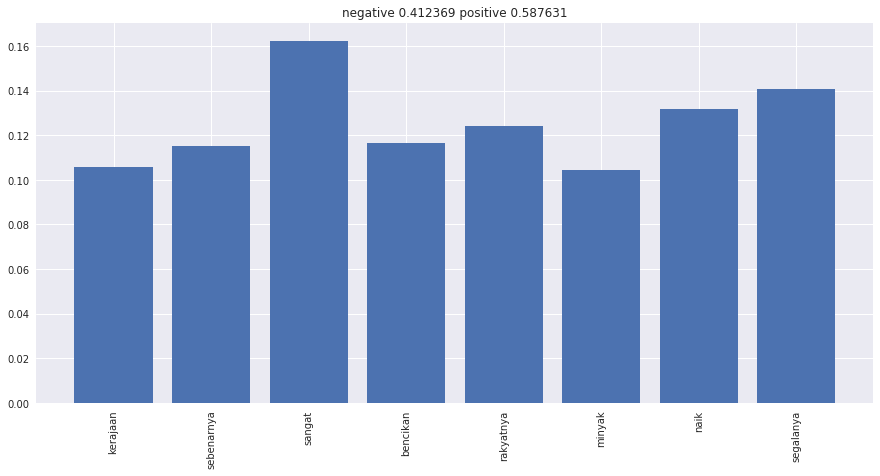

In [27]:
plt.figure(figsize = (15, 7))
labels = [word for word in text[1].split()]
val = [val for val in result[1]]
plt.bar(np.arange(len(labels)), val)
plt.xticks(np.arange(len(labels)), labels, rotation = 'vertical')
plt.title('negative %f positive %f' % (result[0][0,0], result[0][0,1]))
plt.show()